# Artificial Intelligence Computer Assignment 5
### Sepehr Ghobadi / Student No: 810098009

# Aim of Project

In this project we train a neural network on UTKFace dataset ro recognize people's race. throughout the project we studt effect of some parameteres and techniques on classifiers performance

In [505]:
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
import matplotlib.pyplot as plt
import random

# Loading Dataset

In [232]:
data_path = 'UTKFace/'
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(100, 100),
  batch_size=32,
  label_mode="categorical"
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(100, 100),
  batch_size=32,
  label_mode="categorical"
)
races = train_ds.class_names
print(races)

Found 23705 files belonging to 5 classes.
Using 18964 files for training.
Found 23705 files belonging to 5 classes.
Using 4741 files for validation.
['Asian', 'Black', 'Indian', 'Others', 'White']


In [250]:
def dataset_stats(dataset):
    freqs = [0 for i in range(len(races))]
    samples = [None for i in range(len(races))]
    for images, labels in dataset.as_numpy_iterator():
        index=0
        for label in labels:
            for j in range(len(races)):
                if label[j]==1:
                    freqs[j]+=1
                    samples[j]=images[index]
            index+=1

    fig, ax = plt.subplots(figsize=(10,10))
    ax.bar(races, freqs, tick_label=races) 
    
    plt.figure(figsize=(20, 20))
    for index, image in enumerate(samples):
        ax = plt.subplot(1, 5, index + 1)
        plt.imshow(image.astype("uint8"))
        plt.title(races[index])
        plt.axis("off")

In [251]:
dataset_stats(train_ds)

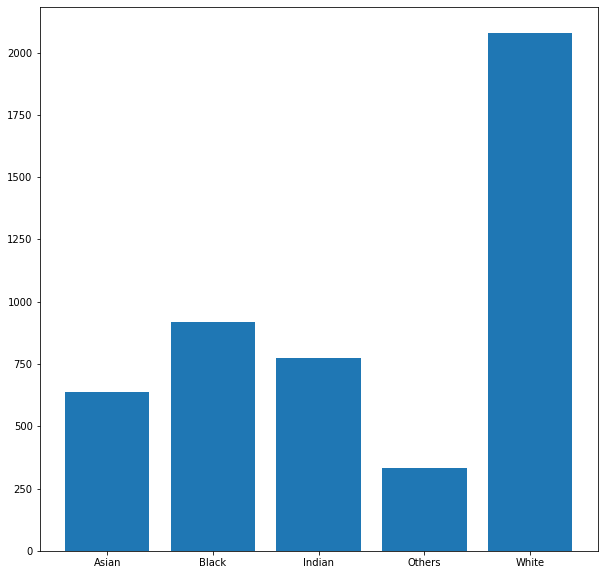

In [252]:
dataset_stats(val_ds)

now we convert images to gray scale:

In [253]:
train_ds = train_ds.map(lambda image, label : (tf.image.rgb_to_grayscale(image), label))
val_ds = val_ds.map(lambda image, label : (tf.image.rgb_to_grayscale(image), label))

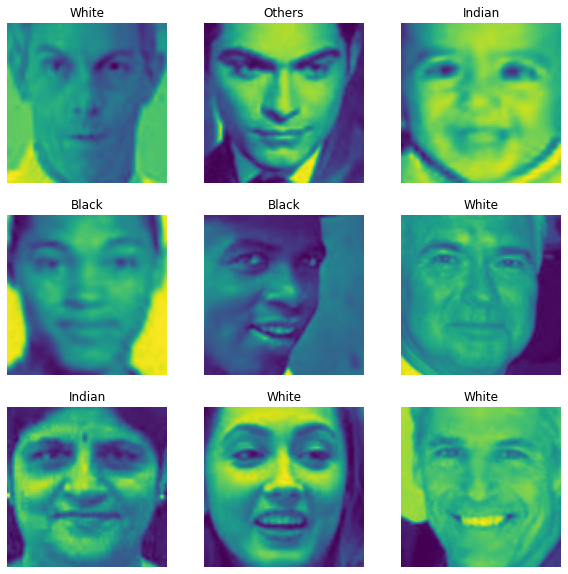

In [296]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(races[np.where(labels[i]==1)[0][0]])
        plt.axis("off")

# 1. Network Architecture

In [389]:
def train(model, train_ds, val_ds, epochs, model_summary=False, log=False):
    if model_summary:
        model.summary()
    model.fit(train_ds, epochs=epochs, verbose=log)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25,6))
    
    ax1.plot(range(1,epochs+1), model.history.history['loss'], color='blue', label='Loss on train data')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss Plot')
    ax1.legend()

    ax2.plot(range(1,epochs+1), model.history.history['accuracy'], color='blue', label='Accuracy on train data')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy Percentage')
    ax2.set_title('Accuracy Plot')
    ax2.legend()
    
    plt.show()
    
    metrics = list(model.history.history.keys())
    print("\n\n\nTrain Results:\nAccuracy: {:.3f}      Recall: {:.3f}      Precision: {:.3f}     F1: {:.3f}".format(model.history.history['accuracy'][-1],model.history.history[metrics[2]][-1],model.history.history[metrics[3]][-1],model.history.history[metrics[4]][-1]))
    model.fit(val_ds, epochs=1, verbose=0)
    print("\nTest Results:\nAccuracy: {:.3f}      Recall: {:.3f}      Precision: {:.3f}     F1: {:.3f}".format(model.history.history['accuracy'][-1],model.history.history[metrics[2]][-1],model.history.history[metrics[3]][-1],model.history.history[metrics[4]][-1]))
    
    
    

In [456]:
def get_model(regularization=False, dropout=False):
    regularizer = None
    if regularization:
        regularizer = keras.regularizers.l2(0.0001)
    inputs = keras.Input(shape=(100, 100))
    net = keras.layers.experimental.preprocessing.Rescaling(scale=1.0 / 255)(inputs)
    net = keras.layers.Flatten()(net)
    net = keras.layers.Dense(400, activation='relu', activity_regularizer=regularizer)(net)
    if dropout:
        net = keras.layers.Dropout(0.1)(net)
    net = keras.layers.Dense(400, activation='relu', activity_regularizer=regularizer)(net)
    if dropout:
        net = keras.layers.Dropout(0.1)(net)
    net = keras.layers.Dense(400, activation='relu', activity_regularizer=regularizer)(net)
    if dropout:
        net = keras.layers.Dropout(0.1)(net)
    outputs = keras.layers.Dense(5, activation="softmax")(net)
    return keras.Model(inputs, outputs)

In [437]:
model = get_model()
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.SGD(learning_rate=0.01), metrics=['accuracy', keras.metrics.Recall(), keras.metrics.Precision(), tfa.metrics.F1Score(average="micro", num_classes=len(races))])

In [438]:
train(model, train_ds, val_ds, epochs=10, model_summary=True, log=True)

Model: "model_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_47 (InputLayer)        [(None, 100, 100)]        0         
_________________________________________________________________
rescaling_27 (Rescaling)     (None, 100, 100)          0         
_________________________________________________________________
flatten_44 (Flatten)         (None, 10000)             0         
_________________________________________________________________
dense_186 (Dense)            (None, 400)               4000400   
_________________________________________________________________
dense_187 (Dense)            (None, 400)               160400    
_________________________________________________________________
dense_188 (Dense)            (None, 400)               160400    
_________________________________________________________________
dense_189 (Dense)            (None, 400)               160




Train Results:
Accuracy: 0.696      Recall: 0.601      Precision: 0.777     F1: 0.696

Test Results:
Accuracy: 0.692      Recall: 0.596      Precision: 0.775     F1: 0.692


# 2. Optimizer

## 2.1 Momentum

Momentum or SGD with momentum is method which helps accelerate gradients vectors in the right directions, thus leading to faster converging. It is one of the most popular optimization algorithms and many state-of-the-art models are trained using it. With Stochastic Gradient Descent we don’t compute the exact derivate of our loss function. Instead, we’re estimating it on a small batch. Which means we’re not always going in the optimal direction, because our derivatives are ‘noisy’. Just like in my graphs above. So, exponentially weighed averages can provide us a better estimate which is closer to the actual derivate than our noisy calculations. This is one reason why momentum might work better than classic SGD.
The other reason lies in ravines. Ravine is an area, where the surface curves much more steeply in one dimension than in another. Ravines are common near local minimas in deep learning and SGD has troubles navigating them. SGD will tend to oscillate across the narrow ravine since the negative gradient will point down one of the steep sides rather than along the ravine towards the optimum.

----    Model With momentum=0.5    -----


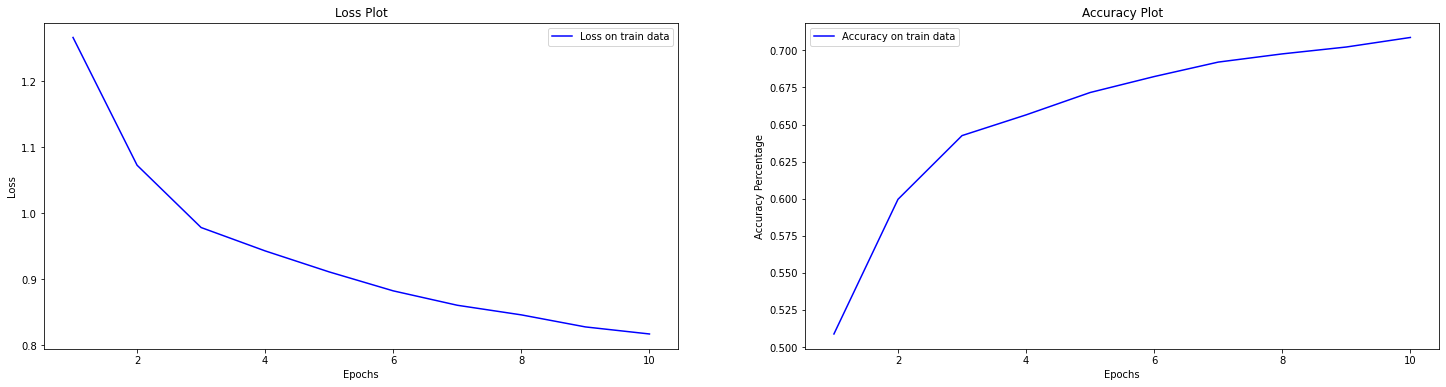




Train Results:
Accuracy: 0.709      Recall: 0.617      Precision: 0.784     F1: 0.709

Test Results:
Accuracy: 0.701      Recall: 0.607      Precision: 0.777     F1: 0.701


----    Model With momentum=0.9    -----


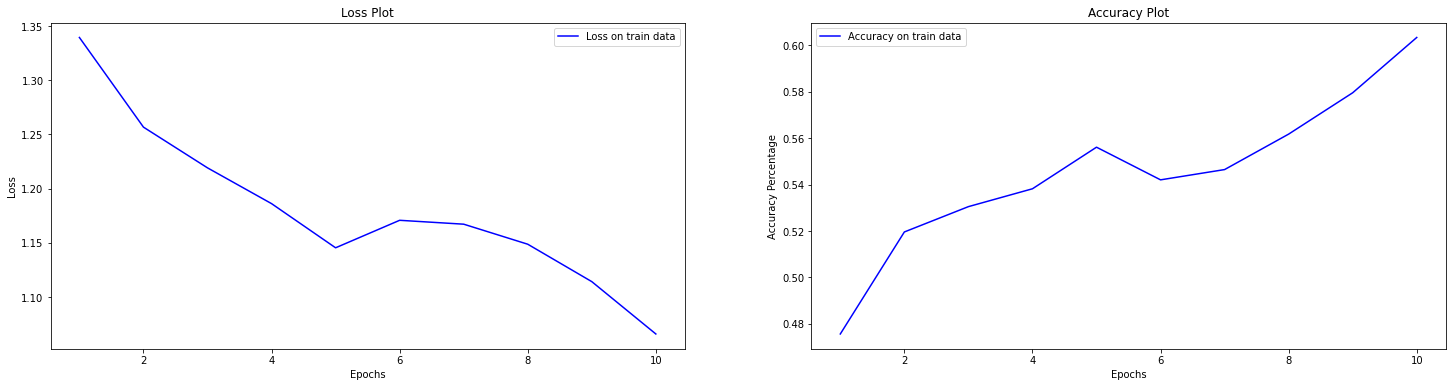




Train Results:
Accuracy: 0.603      Recall: 0.471      Precision: 0.691     F1: 0.603

Test Results:
Accuracy: 0.624      Recall: 0.490      Precision: 0.703     F1: 0.624


In [396]:
model = get_model()
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.5), metrics=['accuracy', keras.metrics.Recall(), keras.metrics.Precision(), tfa.metrics.F1Score(average="micro", num_classes=len(races))])
print("----    Model With momentum=0.5    -----")
train(model, train_ds, val_ds, epochs=10)

model = get_model()
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.9), metrics=['accuracy', keras.metrics.Recall(), keras.metrics.Precision(), tfa.metrics.F1Score(average="micro", num_classes=len(races))])
print("\n\n----    Model With momentum=0.9    -----")
train(model, train_ds, val_ds, epochs=10)

increasing momentum up to a certain level helps model training converge more quickly, since training and validation loss decrease at a faster rate. However, once we go past the proper value, we observe that training loss and validation loss actually suffer, with model training entirely failing to converge at high momentums. This could be because excessively large momentum prevents the model from adapting to new directions in the gradient updates. Another potential reason is that the weight updates become so large that it overshoots the minima.

## 2.2 Adam Optimizer 

----    Model With Adam Optimizer    -----
Epoch 1/10
593/593 [==============================] - 8s 13ms/step - loss: 1.2487 - accuracy: 0.5289 - recall_26: 0.3121 - precision_26: 0.6619 - f1_score: 0.5289
Epoch 2/10
593/593 [==============================] - 8s 13ms/step - loss: 1.0217 - accuracy: 0.6263 - recall_26: 0.4883 - precision_26: 0.7272 - f1_score: 0.6263
Epoch 3/10
593/593 [==============================] - 8s 13ms/step - loss: 0.9438 - accuracy: 0.6571 - recall_26: 0.5422 - precision_26: 0.7494 - f1_score: 0.6571
Epoch 4/10
593/593 [==============================] - 8s 13ms/step - loss: 0.9291 - accuracy: 0.6629 - recall_26: 0.5543 - precision_26: 0.7475 - f1_score: 0.6629
Epoch 5/10
593/593 [==============================] - 8s 13ms/step - loss: 0.8927 - accuracy: 0.6814 - recall_26: 0.5762 - precision_26: 0.7604 - f1_score: 0.6814
Epoch 6/10
593/593 [==============================] - 8s 13ms/step - loss: 0.8801 - accuracy: 0.6848 - recall_26: 0.5843 - precision_26: 0.763

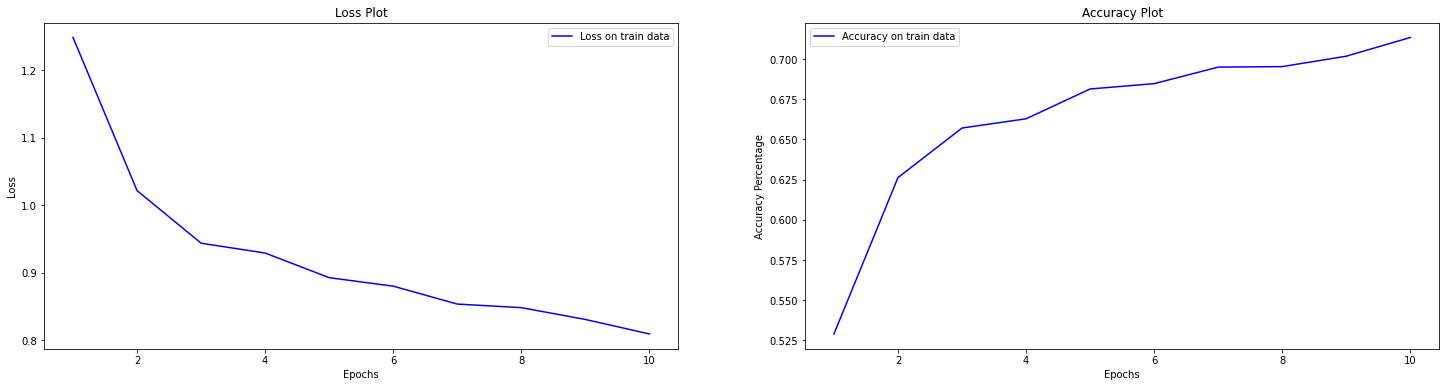




Train Results:
Accuracy: 0.714      Recall: 0.622      Precision: 0.789     F1: 0.714

Test Results:
Accuracy: 0.702      Recall: 0.613      Precision: 0.773     F1: 0.702


In [401]:
model = get_model()
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy', keras.metrics.Recall(), keras.metrics.Precision(), tfa.metrics.F1Score(average="micro", num_classes=len(races))])
print("----    Model With Adam Optimizer    -----")
train(model, train_ds, val_ds, epochs=10, log=True)

# 3. Epochs

In terms of artificial neural networks, an epoch refers to one cycle through the full training dataset. Usually, training a neural network takes more than a few epochs. In other words, if we feed a neural network the training data for more than one epoch in different patterns, we hope for a better generalization when given a new "unseen" input (test data). An epoch is often mixed up with an iteration. Iterations is the number of batches or steps through partitioned packets of the training data, needed to complete one epoch.  Heuristically, one motivation is that (especially for large but finite training sets) it gives the network a chance to see the previous data to readjust the model parameters so that the model is not biased towards the last few data points during training.  
there is no guarantee a network will converge or "get better" by letting it learn the data for multiple epochs. It is an art in machine learning to decide the number of epochs sufficient for a network.
In parallel, when we apply this to other areas of machine learning such as reinforcement learning, we see that an agent may not take the same route to complete the same task. This is because the agent is learning which decisions to make and trying to understand the consequences of such action(s). With a neural network, the goal of the model is generally to classify or generate material which is right or wrong. Thus, an epoch for an experimental agent performing many actions for a single task may vary from an epoch for an agent trying to perform a single action for many tasks of the same nature.  In reinforcement learning terminology, this is more typically referred to as an episode.

he more examples the network see, the better it will learn, and especially the better it will generalize. Ideally, if you train it long enough, it could reach 100% accuracy on this specific task.
The conclusion is that only running 1 epoch is fine, as long as the examples are sampled from the same distribution.

----    Model With 20 Epochs    -----


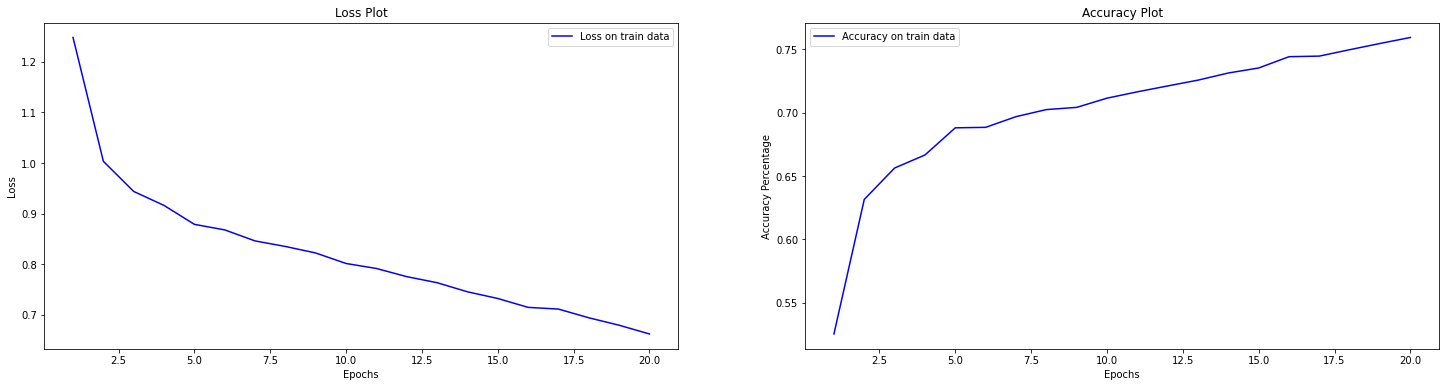




Train Results:
Accuracy: 0.759      Recall: 0.692      Precision: 0.823     F1: 0.759

Test Results:
Accuracy: 0.711      Recall: 0.635      Precision: 0.783     F1: 0.711


In [439]:
model = get_model()
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy', keras.metrics.Recall(), keras.metrics.Precision(), tfa.metrics.F1Score(average="micro", num_classes=len(races))])
print("----    Model With 20 Epochs    -----")
train(model, train_ds, val_ds, epochs=20)

The number of epochs you require will depend on the size of your model and the variation in your dataset.

The size of your model can be a rough proxy for the complexity that it is able to express (or learn). So a huge model can represent produce more nuanced models for datasets with higher diversity in the data, however would probably take longer to train i.e. more epochs.

Whilst training, I would recommend plotting the training and validation loss and keeping an eye on how they progress over epochs and also in relation to one another. You should of course expect both values to decrease, but you need to stop training once the lines start diverging - meaning that you are over-fitting to your specific dataset.

# 4. Loss Function

In [511]:
model = get_model()
model.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy', keras.metrics.Recall(), keras.metrics.Precision(), tfa.metrics.F1Score(average="micro", num_classes=len(races))])
print("----    Model With 20 Epochs    -----")
train(model, train_ds, val_ds, epochs=20, log=True)

----    Model With 20 Epochs    -----
Epoch 1/20
593/593 [==============================] - 17s 27ms/step - loss: 0.2310 - accuracy: 0.4214 - recall_57: 0.4210 - precision_57: 0.4217 - f1_score: 0.4214
Epoch 2/20
  5/593 [..............................] - ETA: 17s - loss: 0.2000 - accuracy: 0.5000 - recall_57: 0.5000 - precision_57: 0.5000 - f1_score: 0.5000

/usr/local/lib/python3.9/site-packages/tensorflow/python/keras/metrics.py:254: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  warnings.warn('Metric %s implements a `reset_states()` method; rename it '


593/593 [==============================] - 17s 28ms/step - loss: 0.2313 - accuracy: 0.4219 - recall_57: 0.4219 - precision_57: 0.4219 - f1_score: 0.4219
Epoch 3/20
593/593 [==============================] - 17s 28ms/step - loss: 0.2313 - accuracy: 0.4219 - recall_57: 0.4219 - precision_57: 0.4219 - f1_score: 0.4219
Epoch 4/20
593/593 [==============================] - 16s 27ms/step - loss: 0.2313 - accuracy: 0.4219 - recall_57: 0.4219 - precision_57: 0.4219 - f1_score: 0.4219
Epoch 5/20
593/593 [==============================] - 16s 27ms/step - loss: 0.2313 - accuracy: 0.4219 - recall_57: 0.4219 - precision_57: 0.4219 - f1_score: 0.4219
Epoch 6/20
593/593 [==============================] - 15s 26ms/step - loss: 0.2313 - accuracy: 0.4219 - recall_57: 0.4219 - precision_57: 0.4219 - f1_score: 0.4219
Epoch 7/20
593/593 [==============================] - 15s 26ms/step - loss: 0.2313 - accuracy: 0.4219 - recall_57: 0.4219 - precision_57: 0.4219 - f1_score: 0.4219
Epoch 8/20
593/593 [=======




Train Results:
Accuracy: 0.422      Recall: 0.422      Precision: 0.422     F1: 0.422

Test Results:
Accuracy: 0.438      Recall: 0.438      Precision: 0.438     F1: 0.438


There are two reasons why Mean Squared Error(MSE) is a bad choice for binary classification problems:
First, using MSE means that we assume that the underlying data has been generated from a normal distribution (a bell-shaped curve). In Bayesian terms this means we assume a Gaussian prior. While in reality, a dataset that can be classified into multiple categories is not from a normal distribution but a Bernoulli distribution.

Secondly, the MSE function is non-convex for binary classification. In simple terms, if a binary classification model is trained with MSE Cost function, it is not guaranteed to minimize the Cost function. This is because MSE function expects real-valued inputs in range(-∞, ∞), while binary classification models output probabilities in range(0,n_classes) through the sigmoid/logistic function.
When the MSE function is passed a value that is unbounded a nice U-shaped (convex) curve is the result where there is a clear minimum point at the target value (y). On the other hand, when a bounded value from a Sigmoid function is passed to the MSE function the result is not convex; on one side the function is concave while on the other side the function convex and no clear minimum point. So, if by accident a binary classification neural network is initialized with weights which are large in magnitude such that it lands on the concave part of the MSE Cost function gradient descent will not work and consequently, weights may not update or improve very slowly(try this out in coding section). This is one of the reasons why neural networks should be carefully initialized with small values when training

# 5. Regularization

In [461]:
model = get_model(regularization=True, dropout=False)
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adamax(learning_rate=0.001), metrics=['accuracy', keras.metrics.Recall(), keras.metrics.Precision(), tfa.metrics.F1Score(average="micro", num_classes=len(races))])
print("----    Model With L2 Regularizer    -----")
train(model, train_ds, val_ds, epochs=20, log=True)

----    Model With L2 Regularizer    -----
Epoch 1/20
593/593 [==============================] - 18s 29ms/step - loss: 1.2695 - accuracy: 0.5255 - recall_54: 0.3141 - precision_54: 0.6674 - f1_score: 0.5255
Epoch 2/20
593/593 [==============================] - 18s 31ms/step - loss: 0.9915 - accuracy: 0.6441 - recall_54: 0.5199 - precision_54: 0.7412 - f1_score: 0.6441
Epoch 3/20
593/593 [==============================] - 17s 28ms/step - loss: 0.9526 - accuracy: 0.6610 - recall_54: 0.5497 - precision_54: 0.7451 - f1_score: 0.6610
Epoch 4/20
593/593 [==============================] - 17s 29ms/step - loss: 0.9244 - accuracy: 0.6698 - recall_54: 0.5645 - precision_54: 0.7543 - f1_score: 0.6698
Epoch 5/20
593/593 [==============================] - 17s 29ms/step - loss: 0.9095 - accuracy: 0.6746 - recall_54: 0.5716 - precision_54: 0.7568 - f1_score: 0.6746
Epoch 6/20
593/593 [==============================] - 18s 30ms/step - loss: 0.8904 - accuracy: 0.6848 - recall_54: 0.5901 - precision_54:




Train Results:
Accuracy: 0.720      Recall: 0.640      Precision: 0.788     F1: 0.720

Test Results:
Accuracy: 0.713      Recall: 0.641      Precision: 0.780     F1: 0.713


as we can see regularization slightly improved results.

## 5.1 Correct Predictions

In [487]:
pred = np.round(model.predict(val_ds))
rgb_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(100, 100),
  batch_size=32,
  label_mode="categorical"
)
index=0
wrongs=[]
corrects=[]
for images, labels in rgb_dataset.as_numpy_iterator():
    cnt=0
    for label in labels:
        flg=0
        y=0
        pr=0
        for j in range(len(races)):
            if label[j]==1:
                y=j
            if pred[index][j]==1:
                pr=j
        if y!=pr:
            wrongs.append((images[cnt],y,pr))
        else:
            corrects.append((images[cnt],y,pr))
        cnt+=1
        index+=1

Found 23705 files belonging to 5 classes.
Using 4741 files for validation.


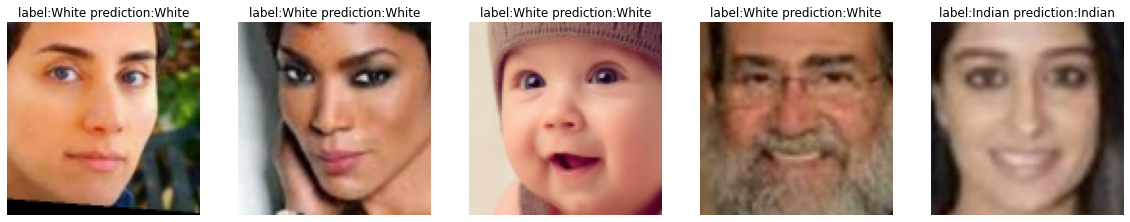

In [499]:
plt.figure(figsize=(20, 20))
index=1
random.shuffle(corrects)
for image, y, pred in corrects[0:5]:
    ax = plt.subplot(2, 5, index)
    index+=1
    plt.imshow(image.astype("uint8"))
    plt.title("label:{} prediction:{}".format(races[y], races[pred]))
    plt.axis("off")

## 5.2 Wrong Predictions

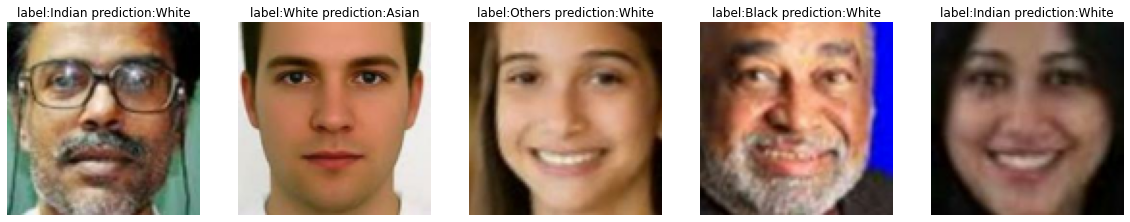

In [504]:
plt.figure(figsize=(20, 20))
index=1
random.shuffle(wrongs)
for image, y, pred in wrongs[0:5]:
    ax = plt.subplot(2, 5, index)
    index+=1
    plt.imshow(image.astype("uint8"))
    plt.title("label:{} prediction:{}".format(races[y], races[pred]))
    plt.axis("off")

# 6. Dropout

----    Model With Drop    -----
Epoch 1/20
593/593 [==============================] - 18s 29ms/step - loss: 1.3626 - accuracy: 0.4774 - recall_55: 0.2431 - precision_55: 0.6108 - f1_score: 0.4774
Epoch 2/20
593/593 [==============================] - 17s 29ms/step - loss: 1.0727 - accuracy: 0.6014 - recall_55: 0.4384 - precision_55: 0.7173 - f1_score: 0.6014
Epoch 3/20
593/593 [==============================] - 17s 29ms/step - loss: 0.9958 - accuracy: 0.6357 - recall_55: 0.5032 - precision_55: 0.7371 - f1_score: 0.6357
Epoch 4/20
593/593 [==============================] - 17s 29ms/step - loss: 0.9515 - accuracy: 0.6543 - recall_55: 0.5334 - precision_55: 0.7499 - f1_score: 0.6543
Epoch 5/20
593/593 [==============================] - 17s 29ms/step - loss: 0.9513 - accuracy: 0.6569 - recall_55: 0.5394 - precision_55: 0.7504 - f1_score: 0.6569
Epoch 6/20
593/593 [==============================] - 18s 30ms/step - loss: 0.9373 - accuracy: 0.6582 - recall_55: 0.5426 - precision_55: 0.7484 - 

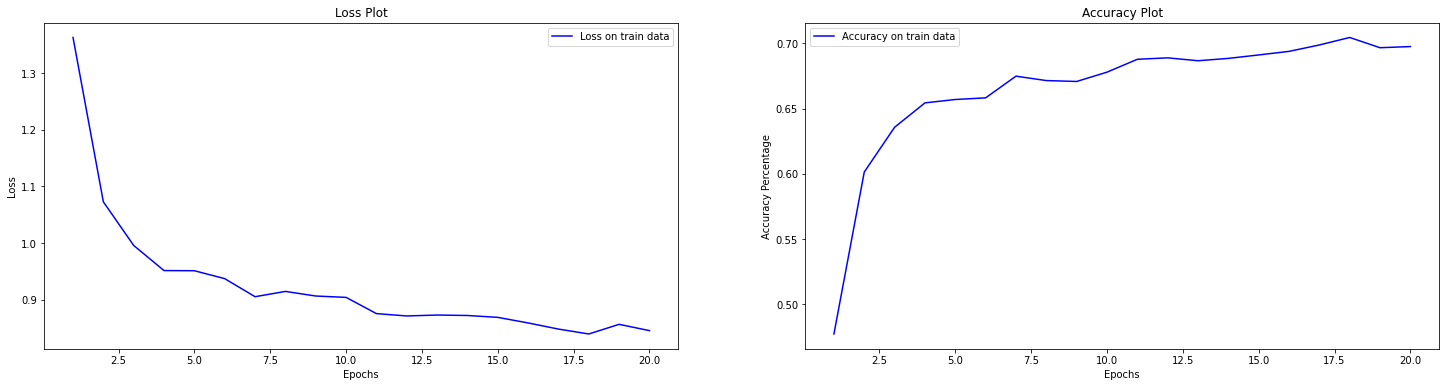




Train Results:
Accuracy: 0.697      Recall: 0.605      Precision: 0.778     F1: 0.697

Test Results:
Accuracy: 0.690      Recall: 0.587      Precision: 0.765     F1: 0.690


In [462]:
model = get_model(regularization=False, dropout=True)
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adamax(learning_rate=0.001), metrics=['accuracy', keras.metrics.Recall(), keras.metrics.Precision(), tfa.metrics.F1Score(average="micro", num_classes=len(races))])
print("----    Model With Drop    -----")
train(model, train_ds, val_ds, epochs=20, log=True)

Dropout is a regularization technique, and is most effective at preventing overfitting. However, there are several places when dropout can hurt performance.

Right before the last layer. This is generally a bad place to apply dropout, because the network has no ability to "correct" errors induced by dropout before the classification happens. If I read correctly, you might have put dropout right before the softmax in the iris MLP.

When the network is small relative to the dataset, regularization is usually unnecessary. If the model capacity is already low, lowering it further by adding regularization will hurt performance. I noticed most of your networks were relatively small and shallow.

When training time is limited. It's unclear if this is the case here, but if you don't train until convergence, dropout may give worse results. Usually dropout hurts performance at the start of training, but results in the final ''converged'' error being lower. Therefore, if you don't plan to train until convergence, you may not want to use dropout.

in this case because of our small network dropout didnt help too much.